Tässä työkirjassa esitellä JSON datan lukeminen verkkosivun käyttämästä julkisen rajapinnan päätepisteestä, datan nopea kartoitus ja jalostaminen visualisointia varten, sekä yksinkertainen visualisointi. Työkirjan erityiset opit ovat datan hakeminen rajapinnasta ja helppo visualisointi seabornin avulla.

Työkirjan tavoitteena on muodostaa visualisointi Liigan eri pelityyppien (harjoitus, runkosarja ja playoff) katsojakeskiarvoista kaudelta 2023-2024, jotta niitä voidaan verrata keskenään luotettavasti.

Ensiksi valittiin haluttu nettisivu, jossa oli sopivaa dataa. Tässä työkirjassa käsitellään liiga.fi-sivustolta saatavia tilastoja, sillä siellä oli helposti saatavilla Liiga-otteluiden tyypit ja katsojakeskiarvot. Rajapinnan päätepisteen löytäminen tapahtui selaimen kehittäjätyökalujen (developer tools) avulla etsimällä "Verkko" (Network) välilehdeltä Fetch/XHR pyyntöjä, joiden URL-osoite sisälsi sanan "api". Tämän jälkeen kutsun "Esikatselu" ja "Vastaus" välilehtiä hyödyntämällä saatiin valittua oikeaa dataa sisältävä rajapinnan päätepiste. 

Datan hakeminen JSON-muotoon halutusta rajapinnan päätepisteestä tapahtui seuraavanlaisesti:

In [1]:
import requests
import pandas as pd
import seaborn as sns

# Tehdään GET pyyntö rajapinnan päätepisteeseen ja erotellan JSON data vastauksen sisällöstä
json_data = requests.get("https://liiga.fi/api/v2/games?tournament=all&season=2024").json()

Datan hakemisen jälkeen siitä muodostettiin pandas dataframe jatkokäsittelyn helpottamiseksi. Dataframen tiedot tulostettiin, jotta dataframen tietoja pystyttiin tarkastelemaan. Dataframesta tarkastettiin, että siitä löytyi pelin tyyppi ja katsojamäärä. Lisäksi näistä katsottiin kyseisten tietojen datatyypit jatkokäsittelyä varten ja että ei-tyhjiä arvoja oli tarpeeksi suuri määrä luotettavuuden varmistamiseksi.

In [2]:
# Tehdän JSON-muotoisesta datasta Pandas dataframe
df = pd.DataFrame(json_data)
# Tulostetaan dataframen tiedot
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               567 non-null    int64  
 1   season           567 non-null    int64  
 2   start            567 non-null    object 
 3   end              545 non-null    object 
 4   homeTeam         567 non-null    object 
 5   awayTeam         567 non-null    object 
 6   finishedType     567 non-null    object 
 7   started          567 non-null    bool   
 8   ended            567 non-null    bool   
 9   gameTime         545 non-null    float64
 10  spectators       545 non-null    float64
 11  cacheUpdateDate  545 non-null    object 
 12  stale            567 non-null    bool   
 13  serie            567 non-null    object 
 14  playOffPair      51 non-null     float64
 15  playOffPhase     51 non-null     float64
 16  playOffReqWins   51 non-null     float64
 17  buyTicketsUrl   

Dataframen tiedoista saatiin selville, että pelin tyypin kolumnin nimi on serie ja katsojamäärä spectators. Dataa vaikutti olevan myös tarpeeksi. Tämän perusteella dataframesta karsittiin epäolennaiset asiat pois ja dataframen tiedot tulostettiin sen tarkastelun avuksi.

In [3]:
# Karsitaan dataframesta epäolennaiset asiat pois
df_rem = df[['serie', 'spectators']].copy()
# Tulostetaan yhteenveto karsitusta dataframesta
df_rem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   serie       567 non-null    object 
 1   spectators  545 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.0+ KB


Dataframen tiedoista huomattiin, että dataframe sisälsi vielä tyhjiä arvoja, joten ne siistittiin pois seuraavasti:

In [4]:
# Siistitään tyhjät arvot pois datasta
df_rem1 = df_rem.dropna()

Seuraavaksi tarkasteltiin vielä eri pelityyppin datamääriä, että yleisökeskiarvojen vertailu olisi laadukasta.

In [5]:
# Tulostetaan kaikki eri pelityypit ja niiden pelimäärät
print(df_rem1['serie'].value_counts())

serie
RUNKOSARJA    450
PRACTICE       66
PLAYOFFS       29
Name: count, dtype: int64


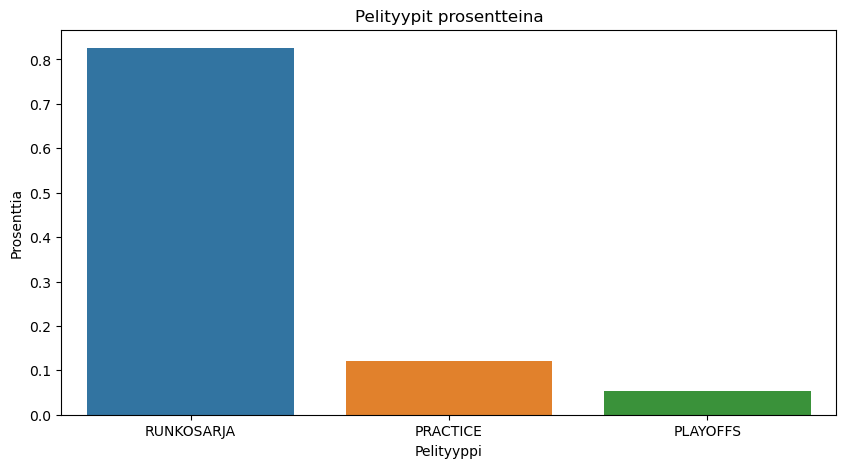

In [6]:
import matplotlib.pyplot as plt

count_serie_percent = df_rem1['serie'].value_counts(normalize=True)
plt.figure(figsize=(10,5))
sns.barplot(x=count_serie_percent.index, y=count_serie_percent.values)
plt.title('Pelityypit prosentteina')
plt.ylabel('Prosenttia')
plt.xlabel('Pelityyppi')
plt.show()

Pelityypeistä huomattiin, että playoff-pelejä oli datassa tekohetkellä vain 5 kappaletta, jolloin niiden katsojakeskiarvon ei voida tulkita olevan vertailukelpoista, sillä se ei sisällä dataa edes jokaisen playoffeihin päässeen joukkueen kotipelistä (yhteensä 10 joukkuetta playoffeissa). Playoff-pelit poistettiinkin datasta ja tämän jälkeen dataframen tiedot tulostettiin, jotta voitiin varmistaa, että tyhjät arvot ja playoff-pelit olivat onnistuneesti poistettu dataframesta.

In [7]:
# Poistetaan playoff-pelit dataframesta
df_rem2 = df_rem1[df_rem1['serie'] != 'PLAYOFFS']
# Tulostetaan yhteenveto dataframesta ilman tyhjiä arvoja ja playoff-pelejä
df_rem2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 0 to 515
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   serie       516 non-null    object 
 1   spectators  516 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.1+ KB


Dataframen tulostetuista tiedoista varmistettiin, että tyhjiä arvoja sisältäneet entryt ja playoff-pelit olivat karsittu datasta onnistuneesti pois. Lopuksi dataframen tiedot visualisoitiin seaborn kirjaston avulla pylväskaavioksi. Tässä visualisoinnissa jätettiin esimerkiksi otsikointi, akselien otsikkojen muokkaaminen ja värien muuttaminen pois koodirivien säästämiseksi. Näihin voisi hyödyntää esimerkiksi matplotlib-kirjastoa.

/tmp/ipykernel_286003/2508523703.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="serie", y="spectators", data=df_rem2, ci=None)


<Axes: xlabel='serie', ylabel='spectators'>

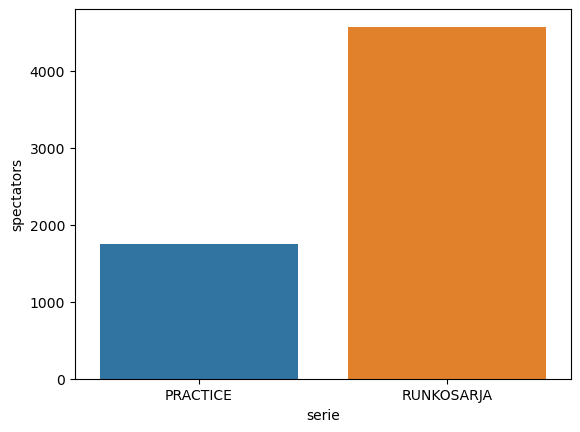

In [8]:
# Visualisoidaan katsojakeskiarvot harjoituspeleissä ja runkosarjapeleissä
sns.barplot(x="serie", y="spectators", data=df_rem2, ci=None)

Visualisoinnista voidaan selkeästi havaita, että Liigan runkosarjapeleissä on yli kaksinkertainen yleisökeskiarvo harjoituskauden peleihin verrattuna. Playoff-pelien katsojakeskiarvoa ei voitu ottaa mukaan vertailuun, sillä data ei sisältänyt tarpeeksi playoff-pelejä, jolloin keskiarvo ei olisi ollut luotettava.